# Machine Learning for Optical Network Security Monitoring: A Practical Perspective

This file contains the implementation of the training and evaluation of the semi-supervised (one-class support vector machine) and unsupervised (DBSCAN) learning strategies considered in the paper.
<p style='color: red'>Note that the dataset is not made available due to confidentiality agreements in place.</p>

For the unsupervised learning strategy (DBSCAN - [see documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)) we evaluate the impact of the following configuration parameters to the accuracy:
- $\epsilon$: The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster.
- $MinPts$: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.

For the semi-supervised learning strategy (OCSVM - [see documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html)) we evaluate the following configuration parameters:
- Kernel: rbf, linear, sigmoid, poly.
- $\gamma$: kernel coefficient.
- $\nu$: An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors.

In the experiments, we also evaluate the impact of the dataset layout to the performance:
- The dataset use, with four different options:
  - Using the full dataset (single dataset for path 1 and path 2) to train a single ANN without specifying which samples comes from which path (we do not have one-hot information for the path).
  - Training the ANN for a single path (two ANNs, one for each path).
  - Using the full dataset to train a single ANN specifying the path which a sample comes from (including two one-hot columns for the path identification).

In [12]:
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn import svm
from sklearn.metrics import f1_score
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython import display

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

base_alpha = .4
alpha_diff = .6

mpl.rcParams['font.size'] = 12
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['lines.markersize'] = 8

figure_format = 'svg'

## Importing dataset

Loading the dataset from the XLSX file, creating some columns and cleaning it using pandas.

<p style='color: red'>Note that the dataset is not made available due to confidentiality agreements in place.</p>

In [2]:
seed = 42
np.random.seed(seed)
folder = '/nobackup/carda/datasets/ml-simulation-optical/2019-ecoc-demo'
final_dataframe = None
file_names = ['BSL', 'INBMOD', 'INBSTRONG', 'OOBMOD', 'OOBSTRONG', 'POLMODbis', 'POLSTRONG']
class_names = ['BSL', 'INBLGT', 'INBSTR', 'OOBLGT', 'OOBSTR', 'POLLGT', 'POLSTR']
for path_e in [1, 2]:
    for idc, clazz in enumerate(file_names):
        print(path_e, clazz)
        dataframe = pd.read_excel(folder + "/" + clazz + '13' + str(path_e) + '.xlsx', 'risultati', header=[0])
        dataframe = dataframe.drop(['n', 'time stamp', 'BE-FEC', 'UBE-FEC', 'OFT', 'OFT-max', 'OFT-min'], axis=1) # removing unused features
        dataframe['path_1'] = 1 if path_e == 1 else 0
        dataframe['path_2'] = 1 if path_e == 2 else 0
        dataframe['attack'] = idc

        dataframe = dataframe[~dataframe.isin([np.nan, np.inf, -np.inf]).any(1)] # remove samples with missing data
        if final_dataframe is None:
            final_dataframe = dataframe
        else:
            final_dataframe = pd.concat([final_dataframe, dataframe], ignore_index=True)

1 BSL
1 INBMOD
1 INBSTRONG
1 OOBMOD
1 OOBSTRONG
1 POLMODbis
1 POLSTRONG
2 BSL
2 INBMOD
2 INBSTRONG
2 OOBMOD
2 OOBSTRONG
2 POLMODbis
2 POLSTRONG


In [3]:
# scaling the dataset
class_columns = ['path_1', 'path_2', 'attack']
scaler = preprocessing.StandardScaler().fit(final_dataframe.drop(class_columns, axis=1))
x_scaled = scaler.transform(final_dataframe.drop(class_columns, axis=1))
scaled_final_dataframe = pd.DataFrame(x_scaled, index=final_dataframe.index, columns=[x for x in final_dataframe.columns if x not in class_columns])
scaled_final_dataframe[class_columns] = final_dataframe[class_columns]
scaled_final_dataframe.describe()

,BER-FEC,BER-FEC-max,BER-FEC-min,BER-POST-FEC,BER-POST-FEC-max,BER-POST-FEC-min,LOSS,OPR,OPR-max,OPR-min,...,OSNR-min,PDL,PDL-max,PDL-min,Q-factor,Q-factor-max,Q-factor-min,path_1,path_2,attack
count,19882.000000,1.988200e+04,1.988200e+04,1.988200e+04,19882.000000,1.988200e+04,19882.0,1.988200e+04,1.988200e+04,1.988200e+04,...,1.988200e+04,1.988200e+04,1.988200e+04,1.988200e+04,1.988200e+04,1.988200e+04,1.988200e+04,19882.000000,19882.000000,19882.000000
mean,0.000000,-5.718079e-18,-9.148926e-17,9.148926e-17,0.000000,-9.148926e-17,0.0,2.676061e-15,-1.074999e-15,-3.339358e-15,...,3.316486e-16,2.287231e-16,-1.143616e-17,-3.202124e-16,1.944147e-16,1.143616e-17,-4.174197e-16,0.500151,0.499849,3.001257
std,1.000025,1.000025e+00,1.000025e+00,1.000025e+00,1.000025,1.000025e+00,0.0,1.000025e+00,1.000025e+00,1.000025e+00,...,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,0.500013,0.500013,2.003003
min,-0.344471,-2.069467e-01,-9.705510e-01,-4.548901e-01,-0.516286,-3.560826e-01,0.0,-1.609655e+00,-1.561280e+00,-1.630550e+00,...,-5.880710e+00,-8.858718e-01,-8.968151e-01,-9.051705e-01,-9.069171e+00,-1.000658e+01,-5.333516e+00,0.000000,0.000000,0.000000
25%,-0.211414,-1.382875e-01,-6.465515e-01,-4.548901e-01,-0.516286,-3.560826e-01,0.0,-5.622683e-01,-5.417011e-01,-5.546669e-01,...,-8.419002e-02,-8.858718e-01,-8.968151e-01,-9.051705e-01,-5.635532e-01,-6.213849e-01,-2.284833e-01,0.000000,0.000000,1.000000
50%,0.009936,-5.750807e-02,1.638493e-01,-4.548901e-01,-0.516286,-3.560826e-01,0.0,-2.225751e-01,-2.301629e-01,-2.149143e-01,...,-3.485829e-03,5.699806e-01,6.336141e-02,-9.051705e-01,-3.096542e-01,-3.453496e-01,3.563608e-03,1.000000,0.000000,3.000000
75%,0.075646,-2.940196e-02,3.659305e-01,-2.473157e-01,-0.320339,-3.041830e-01,0.0,1.171180e-01,1.096969e-01,1.248382e-01,...,5.335342e-01,5.699806e-01,6.336141e-02,1.050769e+00,8.328915e-01,1.034827e+00,5.450064e-01,1.000000,1.000000,5.000000
max,35.834467,1.454732e+01,1.163672e+02,4.062126e+00,2.605030,6.867988e+00,0.0,3.032817e+00,3.055149e+00,3.069360e+00,...,8.831717e-01,1.076095e+01,6.784597e+00,8.874528e+00,2.102387e+00,2.138968e+00,1.318496e+00,1.000000,1.000000,6.000000


## Helper functions

In [4]:
# sort the OCSVM results dictionary by the performance
def get_sorted_pairs_ocsvm(performance):
    values = sorted([[performance[kernel][nu][gamma]['false_positive_rate'], performance[kernel][nu][gamma]['false_negative_rate']] for kernel in performance for nu in performance[kernel] for gamma in performance[kernel][nu]], key=lambda x: x[0])
    return values

# sort the DBSCAN results dictionary by the performance
def get_sorted_pairs_dbscan(performance):
    values = sorted([[performance[min_samples][epsilon]['false_positive_rate'], performance[min_samples][epsilon]['false_negative_rate']] for min_samples in performance for epsilon in performance[min_samples]], key=lambda x: x[0])
    return values

def get_curve(sorted_pairs):
    curve_fpr = []
    curve_fnr = []

    last_x = sorted_pairs[0][0]
    last_y = sorted_pairs[0][1]

    curve_fpr.append(sorted_pairs[0][0])
    curve_fnr.append(sorted_pairs[0][1])
    
    for x, y in sorted_pairs:
        if x > curve_fpr[-1] and y < curve_fnr[-1]:
            curve_fpr.append(x)
            curve_fnr.append(y)
    return curve_fpr, curve_fnr

## Unsupervised learning algorithm (DBSCAN)

In [5]:
num_tests = 50 # number of tests to be performed and obtain average accuracy
samples_normal = 100
samples_abnormal = 15

epsilon_configurations = [.1, .5, 1., 2., 3., 4., 5., 10.]
min_samples_configurations = [3, 5, 8, 10, 12, 15, 20, 50, 80, 100]

In [6]:
### using the full dataset specifying the path

performance_dbscan_oh = {}
highest_f1 = 0.

for idm, min_samples in enumerate(min_samples_configurations):
    performance_dbscan_oh[min_samples] = {}
    for ide, epsilon in enumerate(epsilon_configurations):
        performance_dbscan_oh[min_samples][epsilon] = {}

print('MinPts\tepsilon\t\tfpr\tfnr\tf1')
for idm, min_samples in enumerate(min_samples_configurations):
    
    for ide, epsilon in enumerate(epsilon_configurations):

        clf = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')
        
        true_positives = []
        false_negatives = []
        true_negatives = []
        false_positives = []
        precisions = []
        recalls = []
        f1_scores = []
        
        for test in range(num_tests):
            p1 = scaled_final_dataframe[(scaled_final_dataframe['path_1'] == 1) & (scaled_final_dataframe['attack'] == 0)].sample(samples_normal)
            p2 = scaled_final_dataframe[(scaled_final_dataframe['path_2'] == 1) & (scaled_final_dataframe['attack'] == 0)].sample(samples_normal)
            x_data = np.concatenate((p1.values[:, :-1], p2.values[:, :-1]), axis=0)
            y_data = np.concatenate((p1.values[:, -1], p2.values[:, -1]), axis=0)

            # start copy
            for i in range(num_tests):
                x_data_test = np.copy(x_data)
                y_data_test = np.copy(y_data)
                for clazz in range(1, len(class_names)):
                    x = scaled_final_dataframe[(scaled_final_dataframe['path_1'] == 1) & (scaled_final_dataframe['attack'] == clazz)].sample(samples_abnormal)
                    x_data_test = np.concatenate((x_data_test, x.values[:, :-1]), axis=0)
                    y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)
                    
                    x = scaled_final_dataframe[(scaled_final_dataframe['path_2'] == 1) & (scaled_final_dataframe['attack'] == clazz)].sample(samples_abnormal)
                    x_data_test = np.concatenate((x_data_test, x.values[:, :-1]), axis=0)
                    y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                y_pred = clf.fit_predict(x_data_test)

                tpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])
                fnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])

                tnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])
                fpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])

                if tpr == 0: # avoids division by zero
                    precision = 0.
                    recall = 0.
                    f1 = 0.
                else:
                    precision = tpr / (tpr + fpr)
                    recall = tpr / (tpr + fnr)
                    f1 = 2 * precision * recall / (precision + recall)
                
                true_positives.append(tpr)
                false_negatives.append(fnr)
                true_negatives.append(tnr)
                false_positives.append(fpr)
                precisions.append(precision)
                recalls.append(recall)
                f1_scores.append(f1)
        
        performance_dbscan_oh[min_samples][epsilon]['min_samples'] = min_samples
        performance_dbscan_oh[min_samples][epsilon]['epsilon'] = epsilon
        performance_dbscan_oh[min_samples][epsilon]['true_positive_rate'] = np.mean(true_positives)
        performance_dbscan_oh[min_samples][epsilon]['false_negative_rate'] = np.mean(false_negatives)
        performance_dbscan_oh[min_samples][epsilon]['true_negative_rate'] = np.mean(true_negatives)
        performance_dbscan_oh[min_samples][epsilon]['false_positive_rate'] = np.mean(false_positives)
        performance_dbscan_oh[min_samples][epsilon]['precision'] = np.mean(precisions)
        performance_dbscan_oh[min_samples][epsilon]['recall'] = np.mean(recalls)
        performance_dbscan_oh[min_samples][epsilon]['f1_score'] = np.mean(f1_scores)
        msg = ''
        if performance_dbscan_oh[min_samples][epsilon]['f1_score'] > highest_f1:
            msg = '\t * highest'
            highest_f1 = performance_dbscan_oh[min_samples][epsilon]['f1_score']
        print(f'{min_samples:>6}\t', f'{epsilon:>6}', '\t{:.3f}\t{:.3f}\t{:.3f}\t'.format(performance_dbscan_oh[min_samples][epsilon]['false_positive_rate'],
                performance_dbscan_oh[min_samples][epsilon]['false_negative_rate'],
                performance_dbscan_oh[min_samples][epsilon]['f1_score']), msg)

print('done')

MinPts	epsilon		fpr	fnr	f1
     3	    0.1 	1.000	0.000	0.667	 	 * highest
     3	    0.5 	0.792	0.007	0.713	 	 * highest
     3	    1.0 	0.183	0.256	0.772	 	 * highest
     3	    2.0 	0.002	0.710	0.448	 
     3	    3.0 	0.000	0.850	0.259	 
     3	    4.0 	0.000	0.936	0.120	 
     3	    5.0 	0.000	0.968	0.062	 
     3	   10.0 	0.000	0.992	0.016	 
     5	    0.1 	1.000	0.000	0.667	 
     5	    0.5 	0.911	0.000	0.687	 
     5	    1.0 	0.261	0.153	0.804	 	 * highest
     5	    2.0 	0.001	0.677	0.487	 
     5	    3.0 	0.000	0.793	0.342	 
     5	    4.0 	0.000	0.909	0.166	 
     5	    5.0 	0.000	0.958	0.081	 
     5	   10.0 	0.000	0.991	0.018	 
     8	    0.1 	1.000	0.000	0.667	 
     8	    0.5 	0.965	0.000	0.675	 
     8	    1.0 	0.365	0.095	0.798	 
     8	    2.0 	0.001	0.660	0.506	 
     8	    3.0 	0.000	0.732	0.422	 
     8	    4.0 	0.000	0.859	0.246	 
     8	    5.0 	0.000	0.944	0.105	 
     8	   10.0 	0.000	0.990	0.019	 
    10	    0.1 	1.000	0.000	0.667	 
    10	    0.5 	0.975	0.000	0

In [7]:
# test where performance is assessed for each attack scenario
performance_dbscan_oh = {}
highest_f1 = 0.

for idm, min_samples in enumerate(min_samples_configurations):
    performance_dbscan_oh[min_samples] = {}
    for ide, epsilon in enumerate(epsilon_configurations):
        performance_dbscan_oh[min_samples][epsilon] = {}

print('MinPts\tepsilon\t\tfpr\tfnr\tf1')
for idm, min_samples in enumerate(min_samples_configurations):
    
    for ide, epsilon in enumerate(epsilon_configurations):

        clf = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')
        
        true_positives = []
        false_negatives = []
        true_negatives = []
        false_positives = []
        precisions = []
        recalls = []
        f1_scores = []
        
        for test in range(num_tests):
            p1 = scaled_final_dataframe[(scaled_final_dataframe['path_1'] == 1) & (scaled_final_dataframe['attack'] == 0)].sample(samples_normal)
            p2 = scaled_final_dataframe[(scaled_final_dataframe['path_2'] == 1) & (scaled_final_dataframe['attack'] == 0)].sample(samples_normal)
            x_data = np.concatenate((p1.values[:, :-1], p2.values[:, :-1]), axis=0)
            y_data = np.concatenate((p1.values[:, -1], p2.values[:, -1]), axis=0)

            # start copy
            for clazz in range(1, len(class_names)):
                for i in range(num_tests):
                    x = scaled_final_dataframe[(scaled_final_dataframe['path_1'] == 1) & (scaled_final_dataframe['attack'] == clazz)].sample(samples_abnormal)
                    x_data_test = np.concatenate((x_data, x.values[:, :-1]), axis=0)
                    y_data_test = np.concatenate((y_data, x.values[:, -1]), axis=0)
                    
                    x = scaled_final_dataframe[(scaled_final_dataframe['path_2'] == 1) & (scaled_final_dataframe['attack'] == clazz)].sample(samples_abnormal)
                    x_data_test = np.concatenate((x_data_test, x.values[:, :-1]), axis=0)
                    y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                    y_pred = clf.fit_predict(x_data_test)

                    tpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])
                    fnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])

                    tnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])
                    fpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])

                    if tpr == 0: # avoids division by zero
                        precision = 0.
                        recall = 0.
                        f1 = 0.
                    else:
                        precision = tpr / (tpr + fpr)
                        recall = tpr / (tpr + fnr)
                        f1 = 2 * precision * recall / (precision + recall)

                    true_positives.append(tpr)
                    false_negatives.append(fnr)
                    true_negatives.append(tnr)
                    false_positives.append(fpr)
                    precisions.append(precision)
                    recalls.append(recall)
                    f1_scores.append(f1)
        performance_dbscan_oh[min_samples][epsilon]['min_samples'] = min_samples
        performance_dbscan_oh[min_samples][epsilon]['epsilon'] = epsilon
        performance_dbscan_oh[min_samples][epsilon]['true_positive_rate'] = np.mean(true_positives)
        performance_dbscan_oh[min_samples][epsilon]['false_negative_rate'] = np.mean(false_negatives)
        performance_dbscan_oh[min_samples][epsilon]['true_negative_rate'] = np.mean(true_negatives)
        performance_dbscan_oh[min_samples][epsilon]['false_positive_rate'] = np.mean(false_positives)
        performance_dbscan_oh[min_samples][epsilon]['precision'] = np.mean(precisions)
        performance_dbscan_oh[min_samples][epsilon]['recall'] = np.mean(recalls)
        performance_dbscan_oh[min_samples][epsilon]['f1_score'] = np.mean(f1_scores)
        msg = ''
        if performance_dbscan_oh[min_samples][epsilon]['f1_score'] > highest_f1:
            msg = '\t * highest'
            highest_f1 = performance_dbscan_oh[min_samples][epsilon]['f1_score']
        print(f'{min_samples:>6}', f'{epsilon:>6}', '\t{:.3f}\t{:.3f}\t{:.3f}\t'.format(performance_dbscan_oh[min_samples][epsilon]['false_positive_rate'],
                performance_dbscan_oh[min_samples][epsilon]['false_negative_rate'],
                performance_dbscan_oh[min_samples][epsilon]['f1_score']), msg)

print('done')

MinPts	epsilon		fpr	fnr	f1
     3    0.1 	1.000	0.000	0.667	 	 * highest
     3    0.5 	0.794	0.007	0.713	 	 * highest
     3    1.0 	0.180	0.240	0.770	 	 * highest
     3    2.0 	0.002	0.698	0.343	 
     3    3.0 	0.000	0.817	0.226	 
     3    4.0 	0.000	0.917	0.124	 
     3    5.0 	0.000	0.961	0.065	 
     3   10.0 	0.000	0.991	0.016	 
     5    0.1 	1.000	0.000	0.667	 
     5    0.5 	0.905	0.000	0.688	 
     5    1.0 	0.267	0.138	0.803	 	 * highest
     5    2.0 	0.002	0.667	0.370	 
     5    3.0 	0.000	0.753	0.277	 
     5    4.0 	0.000	0.868	0.179	 
     5    5.0 	0.000	0.944	0.091	 
     5   10.0 	0.000	0.991	0.017	 
     8    0.1 	1.000	0.000	0.667	 
     8    0.5 	0.960	0.000	0.676	 
     8    1.0 	0.398	0.088	0.787	 
     8    2.0 	0.002	0.646	0.395	 
     8    3.0 	0.000	0.713	0.306	 
     8    4.0 	0.000	0.772	0.264	 
     8    5.0 	0.000	0.900	0.148	 
     8   10.0 	0.000	0.990	0.019	 
    10    0.1 	1.000	0.000	0.667	 
    10    0.5 	0.982	0.000	0.671	 
    10    1.0 	0.46

In [8]:
### using the full dataset without specifying the path

performance_dbscan_fd = {}
highest_f1 = .0

for idm, min_samples in enumerate(min_samples_configurations):
    performance_dbscan_fd[min_samples] = {}
    for ide, epsilon in enumerate(epsilon_configurations):
        performance_dbscan_fd[min_samples][epsilon] = {}

print('MinPts\tepsilon\t\tfpr\tfnr\tf1')
for idm, min_samples in enumerate(min_samples_configurations):
    
    for ide, epsilon in enumerate(epsilon_configurations):

        clf = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')
        
        true_positives = []
        false_negatives = []
        true_negatives = []
        false_positives = []
        precisions = []
        recalls = []
        f1_scores = []
        
        for test in range(num_tests):
            p1 = scaled_final_dataframe[(scaled_final_dataframe['path_1'] == 1) & (scaled_final_dataframe['attack'] == 0)].sample(samples_normal)
            p2 = scaled_final_dataframe[(scaled_final_dataframe['path_2'] == 1) & (scaled_final_dataframe['attack'] == 0)].sample(samples_normal)
            x_data = np.concatenate((p1.values[:, :-3], p2.values[:, :-3]), axis=0)
            y_data = np.concatenate((p1.values[:, -1], p2.values[:, -1]), axis=0)

            # start copy
            for i in range(num_tests):
                x_data_test = np.copy(x_data)
                y_data_test = np.copy(y_data)
                for clazz in range(1, len(class_names)):
                    x = scaled_final_dataframe[(scaled_final_dataframe['path_1'] == 1) & (scaled_final_dataframe['attack'] == clazz)].sample(samples_abnormal)
                    x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                    y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)
                    
                    x = scaled_final_dataframe[(scaled_final_dataframe['path_2'] == 1) & (scaled_final_dataframe['attack'] == clazz)].sample(samples_abnormal)
                    x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                    y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                y_pred = clf.fit_predict(x_data_test)

                tpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])
                fnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])

                tnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])
                fpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])

                if tpr == 0: # avoids division by zero
                    precision = 0.
                    recall = 0.
                    f1 = 0.
                else:
                    precision = tpr / (tpr + fpr)
                    recall = tpr / (tpr + fnr)
                    f1 = 2 * precision * recall / (precision + recall)

                true_positives.append(tpr)
                false_negatives.append(fnr)
                true_negatives.append(tnr)
                false_positives.append(fpr)
                precisions.append(precision)
                recalls.append(recall)
                f1_scores.append(f1)
                
        performance_dbscan_fd[min_samples][epsilon]['true_positive_rate'] = np.mean(true_positives)
        performance_dbscan_fd[min_samples][epsilon]['false_negative_rate'] = np.mean(false_negatives)
        performance_dbscan_fd[min_samples][epsilon]['true_negative_rate'] = np.mean(true_negatives)
        performance_dbscan_fd[min_samples][epsilon]['false_positive_rate'] = np.mean(false_positives)
        performance_dbscan_fd[min_samples][epsilon]['precision'] = np.mean(precisions)
        performance_dbscan_fd[min_samples][epsilon]['recall'] = np.mean(recalls)
        performance_dbscan_fd[min_samples][epsilon]['f1_score'] = np.mean(f1_scores)
        msg = ''
        if performance_dbscan_fd[min_samples][epsilon]['f1_score'] > highest_f1:
            msg = '\t * highest'
            highest_f1 = performance_dbscan_fd[min_samples][epsilon]['f1_score']
        print(f'{min_samples:>6}', f'{epsilon:>6}', '\t{:.3f}\t{:.3f}\t{:.3f}\t'.format(performance_dbscan_fd[min_samples][epsilon]['false_positive_rate'],
                performance_dbscan_fd[min_samples][epsilon]['false_negative_rate'],
                performance_dbscan_fd[min_samples][epsilon]['f1_score']), msg)
        
print('done')

MinPts	epsilon		fpr	fnr	f1
     3    0.1 	1.000	0.000	0.667	 	 * highest
     3    0.5 	0.776	0.007	0.717	 	 * highest
     3    1.0 	0.181	0.258	0.771	 	 * highest
     3    2.0 	0.001	0.709	0.450	 
     3    3.0 	0.000	0.849	0.261	 
     3    4.0 	0.000	0.936	0.120	 
     3    5.0 	0.000	0.968	0.063	 
     3   10.0 	0.000	0.992	0.016	 
     5    0.1 	1.000	0.000	0.667	 
     5    0.5 	0.909	0.000	0.687	 
     5    1.0 	0.269	0.153	0.800	 	 * highest
     5    2.0 	0.001	0.677	0.487	 
     5    3.0 	0.000	0.793	0.341	 
     5    4.0 	0.000	0.909	0.165	 
     5    5.0 	0.000	0.957	0.081	 
     5   10.0 	0.000	0.991	0.017	 
     8    0.1 	1.000	0.000	0.667	 
     8    0.5 	0.965	0.000	0.675	 
     8    1.0 	0.381	0.095	0.792	 
     8    2.0 	0.001	0.660	0.507	 
     8    3.0 	0.000	0.731	0.424	 
     8    4.0 	0.000	0.859	0.245	 
     8    5.0 	0.000	0.944	0.105	 
     8   10.0 	0.000	0.991	0.019	 
    10    0.1 	1.000	0.000	0.667	 
    10    0.5 	0.976	0.000	0.672	 
    10    1.0 	0.46

In [9]:
### using only path 1

performance_dbscan_p1 = {}
highest_f1 = .0

for idm, min_samples in enumerate(min_samples_configurations):
    performance_dbscan_p1[min_samples] = {}
    for ide, epsilon in enumerate(epsilon_configurations):
        performance_dbscan_p1[min_samples][epsilon] = {}

print('MinPts\tepsilon\t\tfpr\tfnr\tf1')
for idm, min_samples in enumerate(min_samples_configurations):
    
    for ide, epsilon in enumerate(epsilon_configurations):

        clf = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')
        
        true_positives = []
        false_negatives = []
        true_negatives = []
        false_positives = []
        precisions = []
        recalls = []
        f1_scores = []
        
        for test in range(num_tests):
            p1 = scaled_final_dataframe[(scaled_final_dataframe['path_1'] == 1) & (scaled_final_dataframe['attack'] == 0)].sample(samples_normal)
            x_data = p1.values[:, :-3]
            y_data = p1.values[:, -1]

            # start copy
            for i in range(num_tests):
                x_data_test = np.copy(x_data)
                y_data_test = np.copy(y_data)
                for clazz in range(1, len(class_names)):
                    x = scaled_final_dataframe[(scaled_final_dataframe['path_1'] == 1) & (scaled_final_dataframe['attack'] == clazz)].sample(samples_abnormal)
                    x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                    y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                y_pred = clf.fit_predict(x_data_test)

                tpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])
                fnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])

                tnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])
                fpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])

                if tpr == 0: # avoids division by zero
                    precision = 0.
                    recall = 0.
                    f1 = 0.
                else:
                    precision = tpr / (tpr + fpr)
                    recall = tpr / (tpr + fnr)
                    f1 = 2 * precision * recall / (precision + recall)

                true_positives.append(tpr)
                false_negatives.append(fnr)
                true_negatives.append(tnr)
                false_positives.append(fpr)
                precisions.append(precision)
                recalls.append(recall)
                f1_scores.append(f1)
                
        performance_dbscan_p1[min_samples][epsilon]['true_positive_rate'] = np.mean(true_positives)
        performance_dbscan_p1[min_samples][epsilon]['false_negative_rate'] = np.mean(false_negatives)
        performance_dbscan_p1[min_samples][epsilon]['true_negative_rate'] = np.mean(true_negatives)
        performance_dbscan_p1[min_samples][epsilon]['false_positive_rate'] = np.mean(false_positives)
        performance_dbscan_p1[min_samples][epsilon]['precision'] = np.mean(precisions)
        performance_dbscan_p1[min_samples][epsilon]['recall'] = np.mean(recalls)
        performance_dbscan_p1[min_samples][epsilon]['f1_score'] = np.mean(f1_scores)
        msg = ''
        if performance_dbscan_p1[min_samples][epsilon]['f1_score'] > highest_f1:
            msg = '\t * highest'
            highest_f1 = performance_dbscan_p1[min_samples][epsilon]['f1_score']
        print(f'{min_samples:>6}', f'{epsilon:>6}', '\t{:.3f}\t{:.3f}\t{:.3f}\t'.format(performance_dbscan_p1[min_samples][epsilon]['false_positive_rate'],
                performance_dbscan_p1[min_samples][epsilon]['false_negative_rate'],
                performance_dbscan_p1[min_samples][epsilon]['f1_score']), msg)
print('done')

MinPts	epsilon		fpr	fnr	f1
     3    0.1 	1.000	0.000	0.667	 	 * highest
     3    0.5 	0.859	0.009	0.696	 	 * highest
     3    1.0 	0.172	0.352	0.711	 	 * highest
     3    2.0 	0.001	0.707	0.452	 
     3    3.0 	0.000	0.829	0.290	 
     3    4.0 	0.000	0.923	0.142	 
     3    5.0 	0.000	0.968	0.062	 
     3   10.0 	0.000	0.989	0.022	 
     5    0.1 	1.000	0.000	0.667	 
     5    0.5 	0.969	0.001	0.673	 
     5    1.0 	0.245	0.234	0.762	 	 * highest
     5    2.0 	0.001	0.671	0.494	 
     5    3.0 	0.000	0.770	0.370	 
     5    4.0 	0.000	0.888	0.198	 
     5    5.0 	0.000	0.960	0.077	 
     5   10.0 	0.000	0.989	0.023	 
     8    0.1 	1.000	0.000	0.667	 
     8    0.5 	0.998	0.000	0.667	 
     8    1.0 	0.358	0.155	0.768	 	 * highest
     8    2.0 	0.001	0.654	0.514	 
     8    3.0 	0.000	0.695	0.465	 
     8    4.0 	0.000	0.816	0.306	 
     8    5.0 	0.000	0.938	0.115	 
     8   10.0 	0.000	0.988	0.024	 
    10    0.1 	1.000	0.000	0.667	 
    10    0.5 	1.000	0.000	0.667	 
    10  

In [10]:
### using only path 2

performance_dbscan_p2 = {}
highest_f1 = .0

for idm, min_samples in enumerate(min_samples_configurations):
    performance_dbscan_p2[min_samples] = {}
    for ide, epsilon in enumerate(epsilon_configurations):
        performance_dbscan_p2[min_samples][epsilon] = {}

print('MinPts\tepsilon\t\tfpr\tfnr\tf1')
for idm, min_samples in enumerate(min_samples_configurations):
    
    for ide, epsilon in enumerate(epsilon_configurations):

        clf = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')
        
        true_positives = []
        false_negatives = []
        true_negatives = []
        false_positives = []
        precisions = []
        recalls = []
        f1_scores = []
        
        for test in range(num_tests):
            p2 = scaled_final_dataframe[(scaled_final_dataframe['path_2'] == 1) & (scaled_final_dataframe['attack'] == 0)].sample(samples_normal)
            x_data = p2.values[:, :-3]
            y_data = p2.values[:, -1]

            # start copy
            for i in range(num_tests):
                x_data_test = np.copy(x_data)
                y_data_test = np.copy(y_data)
                for clazz in range(1, len(class_names)):
                    x = scaled_final_dataframe[(scaled_final_dataframe['path_2'] == 1) & (scaled_final_dataframe['attack'] == clazz)].sample(samples_abnormal)
                    x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                    y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                y_pred = clf.fit_predict(x_data_test)

                tpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])
                fnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])

                tnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])
                fpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])

                if tpr == 0: # avoids division by zero
                    precision = 0.
                    recall = 0.
                    f1 = 0.
                else:
                    precision = tpr / (tpr + fpr)
                    recall = tpr / (tpr + fnr)
                    f1 = 2 * precision * recall / (precision + recall)

                true_positives.append(tpr)
                false_negatives.append(fnr)
                true_negatives.append(tnr)
                false_positives.append(fpr)
                precisions.append(precision)
                recalls.append(recall)
                f1_scores.append(f1)
                
        performance_dbscan_p2[min_samples][epsilon]['true_positive_rate'] = np.mean(true_positives)
        performance_dbscan_p2[min_samples][epsilon]['false_negative_rate'] = np.mean(false_negatives)
        performance_dbscan_p2[min_samples][epsilon]['true_negative_rate'] = np.mean(true_negatives)
        performance_dbscan_p2[min_samples][epsilon]['false_positive_rate'] = np.mean(false_positives)
        performance_dbscan_p2[min_samples][epsilon]['precision'] = np.mean(precisions)
        performance_dbscan_p2[min_samples][epsilon]['recall'] = np.mean(recalls)
        performance_dbscan_p2[min_samples][epsilon]['f1_score'] = np.mean(f1_scores)
        msg = ''
        if performance_dbscan_p2[min_samples][epsilon]['f1_score'] > highest_f1:
            msg = '\t * highest'
            highest_f1 = performance_dbscan_p2[min_samples][epsilon]['f1_score']
        print(f'{min_samples:>6}', f'{epsilon:>6}', '\t{:.3f}\t{:.3f}\t{:.3f}\t'.format(performance_dbscan_p2[min_samples][epsilon]['false_positive_rate'],
                performance_dbscan_p2[min_samples][epsilon]['false_negative_rate'],
                performance_dbscan_p2[min_samples][epsilon]['f1_score']), msg)
        
print('done')

MinPts	epsilon		fpr	fnr	f1
     3    0.1 	1.000	0.000	0.667	 	 * highest
     3    0.5 	0.729	0.006	0.731	 	 * highest
     3    1.0 	0.203	0.165	0.819	 	 * highest
     3    2.0 	0.003	0.712	0.445	 
     3    3.0 	0.000	0.867	0.233	 
     3    4.0 	0.000	0.948	0.098	 
     3    5.0 	0.000	0.968	0.062	 
     3   10.0 	0.000	0.995	0.011	 
     5    0.1 	1.000	0.000	0.667	 
     5    0.5 	0.856	0.000	0.700	 
     5    1.0 	0.289	0.069	0.839	 	 * highest
     5    2.0 	0.002	0.683	0.479	 
     5    3.0 	0.000	0.812	0.314	 
     5    4.0 	0.000	0.933	0.125	 
     5    5.0 	0.000	0.955	0.085	 
     5   10.0 	0.000	0.993	0.013	 
     8    0.1 	1.000	0.000	0.667	 
     8    0.5 	0.937	0.000	0.681	 
     8    1.0 	0.382	0.035	0.823	 
     8    2.0 	0.003	0.666	0.498	 
     8    3.0 	0.000	0.768	0.375	 
     8    4.0 	0.000	0.903	0.174	 
     8    5.0 	0.000	0.952	0.091	 
     8   10.0 	0.000	0.992	0.015	 
    10    0.1 	1.000	0.000	0.667	 
    10    0.5 	0.965	0.000	0.675	 
    10    1.0 	0.46

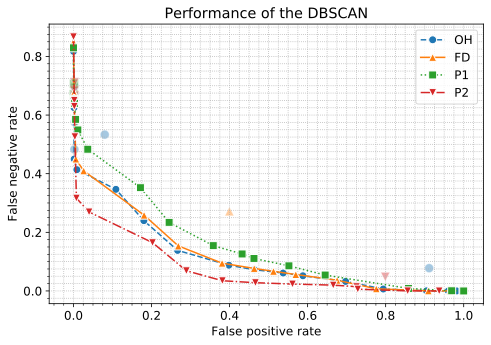

In [13]:
plt.figure(figsize=(7,5))

sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_oh)
curve_fpr, curve_fnr = get_curve(sorted_pairs)

ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           marker='o', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot(curve_fpr, curve_fnr, ls='--', marker='o', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='OH')

sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_fd)
curve_fpr, curve_fnr = get_curve(sorted_pairs)

ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           marker='^', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot(curve_fpr, curve_fnr, ls='-', marker='^', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='FD')

sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_p1)
curve_fpr, curve_fnr = get_curve(sorted_pairs)

ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           marker='s', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot(curve_fpr, curve_fnr, ls=':', marker='s', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='P1')


sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_p2)
curve_fpr, curve_fnr = get_curve(sorted_pairs)

ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           marker='v', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot(curve_fpr, curve_fnr, ls='-.', marker='v', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='P2')

plt.title('Performance of the DBSCAN')
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
plt.grid(True, which='both')
plt.gca().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(8))
plt.gca().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(8))
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'./figures/dbscan-performance.{figure_format}')
plt.show()

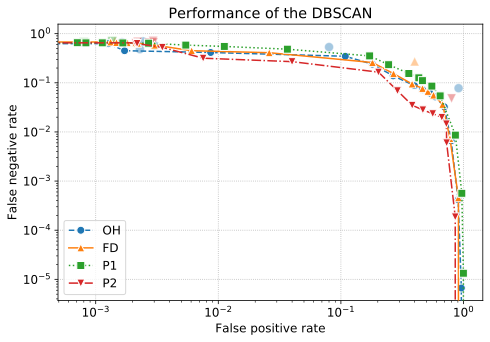

In [14]:
# plotting performance in log scale
plt.figure(figsize=(7,5))

# plotting one-hot
sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_oh)
curve_fpr, curve_fnr = get_curve(sorted_pairs)
ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           marker='o', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot(curve_fpr, curve_fnr, ls='--', marker='o', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='OH')

# plotting full dataset
sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_fd)
curve_fpr, curve_fnr = get_curve(sorted_pairs)
ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           marker='^', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot(curve_fpr, curve_fnr, ls='-', marker='^', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='FD')

# plotting path 1
sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_p1)
curve_fpr, curve_fnr = get_curve(sorted_pairs)
ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           marker='s', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot(curve_fpr, curve_fnr, ls=':', marker='s', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='P1')

# plotting path 2
sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_p2)
curve_fpr, curve_fnr = get_curve(sorted_pairs)
ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           marker='v', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot(curve_fpr, curve_fnr, ls='-.', marker='v', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='P2')

plt.title('Performance of the DBSCAN')
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
plt.grid(True)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig(f'./figures/dbscan-performance-log.{figure_format}')
plt.show()

## Semi-supervised learning algorithm (OCSVM)

In [15]:
gammas = [0.001, 0.1, 0.2, 0.5, 0.7, 1.0]
kernels = ['rbf', 'linear', 'sigmoid', 'poly']
nus = [0.01, 0.1, .3, .5, .7, 1.]

In [16]:
performance_ocsvm_oh = {}
highest_f1 = .0

for kernel in kernels:
    performance_ocsvm_oh[kernel] = {}
    for nu in nus:
        performance_ocsvm_oh[kernel][nu] = {}
        for gamma in gammas:
            performance_ocsvm_oh[kernel][nu][gamma] = {}

print('    kernel\t    nu\t gamma\t\tfpr\tfnr\tf1')
for kernel in kernels:
    for nu in nus:
        for gamma in gammas:
            
            clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
            true_positives = []
            false_negatives = []
            true_negatives = []
            false_positives = []
            precisions = []
            recalls = []
            f1_scores = []
            for i in range(num_tests):
                p1 = scaled_final_dataframe[(scaled_final_dataframe['path_1'] == 1) & (scaled_final_dataframe['attack'] == 0)].sample(samples_normal)
                p2 = scaled_final_dataframe[(scaled_final_dataframe['path_2'] == 1) & (scaled_final_dataframe['attack'] == 0)].sample(samples_normal)
                x_data = np.concatenate((p1.values[:, :-1], p2.values[:, :-1]), axis=0)
                y_data = np.concatenate((p1.values[:, -1], p2.values[:, -1]), axis=0)
                
                clf.fit(x_data)
                
                for test in range(num_tests):
                    x_data_test = np.copy(x_data)
                    y_data_test = np.copy(y_data)
                    for clazz in range(1, len(class_names)):
                        x = scaled_final_dataframe[(scaled_final_dataframe['path_1'] == 1) & (scaled_final_dataframe['attack'] == clazz)].sample(samples_abnormal)
                        x_data_test = np.concatenate((x_data_test, x.values[:, :-1]), axis=0)
                        y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                        x = scaled_final_dataframe[(scaled_final_dataframe['path_2'] == 1) & (scaled_final_dataframe['attack'] == clazz)].sample(samples_abnormal)
                        x_data_test = np.concatenate((x_data_test, x.values[:, :-1]), axis=0)
                        y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                    y_pred = clf.predict(x_data_test)
    
                    tpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])
                    fnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])

                    tnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])
                    fpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])

                    if tpr == 0: # avoids division by zero
                        precision = 0.
                        recall = 0.
                        f1 = 0.
                    else:
                        precision = tpr / (tpr + fpr)
                        recall = tpr / (tpr + fnr)
                        f1 = 2 * precision * recall / (precision + recall)

                    true_positives.append(tpr)
                    false_negatives.append(fnr)
                    true_negatives.append(tnr)
                    false_positives.append(fpr)
                    precisions.append(precision)
                    recalls.append(recall)
                    f1_scores.append(f1)
            
            performance_ocsvm_oh[kernel][nu][gamma]['true_positive_rate'] = np.mean(true_positives)
            performance_ocsvm_oh[kernel][nu][gamma]['false_negative_rate'] = np.mean(false_negatives)
            performance_ocsvm_oh[kernel][nu][gamma]['true_negative_rate'] = np.mean(true_negatives)
            performance_ocsvm_oh[kernel][nu][gamma]['false_positive_rate'] = np.mean(false_positives)
            performance_ocsvm_oh[kernel][nu][gamma]['precision'] = np.mean(precisions)
            performance_ocsvm_oh[kernel][nu][gamma]['recall'] = np.mean(recalls)
            performance_ocsvm_oh[kernel][nu][gamma]['f1_score'] = np.mean(f1_scores)
            msg = ''
            if performance_ocsvm_oh[kernel][nu][gamma]['f1_score'] > highest_f1:
                msg = '\t * highest'
                highest_f1 = performance_ocsvm_oh[kernel][nu][gamma]['f1_score']
            print(f'{kernel:>10}\t', f'{nu:>6}\t', f'{gamma:>6}', '\t{:.3f}\t{:.3f}\t{:.3f}\t'.format(performance_ocsvm_oh[kernel][nu][gamma]['false_positive_rate'],
                    performance_ocsvm_oh[kernel][nu][gamma]['false_negative_rate'],
                    performance_ocsvm_oh[kernel][nu][gamma]['f1_score']), msg)
print('done')

    kernel	    nu	 gamma		fpr	fnr	f1
       rbf	   0.01	  0.001 	0.011	0.580	0.582	 	 * highest
       rbf	   0.01	    0.1 	0.048	0.237	0.842	 	 * highest
       rbf	   0.01	    0.2 	0.079	0.148	0.882	 	 * highest
       rbf	   0.01	    0.5 	0.169	0.028	0.908	 	 * highest
       rbf	   0.01	    0.7 	0.227	0.009	0.893	 
       rbf	   0.01	    1.0 	0.296	0.002	0.870	 
       rbf	    0.1	  0.001 	0.099	0.360	0.736	 
       rbf	    0.1	    0.1 	0.103	0.204	0.838	 
       rbf	    0.1	    0.2 	0.108	0.144	0.872	 
       rbf	    0.1	    0.5 	0.167	0.027	0.909	 	 * highest
       rbf	    0.1	    0.7 	0.223	0.010	0.895	 
       rbf	    0.1	    1.0 	0.284	0.002	0.875	 
       rbf	    0.3	  0.001 	0.300	0.259	0.726	 
       rbf	    0.3	    0.1 	0.299	0.095	0.821	 
       rbf	    0.3	    0.2 	0.301	0.070	0.834	 
       rbf	    0.3	    0.5 	0.303	0.022	0.857	 
       rbf	    0.3	    0.7 	0.305	0.010	0.863	 
       rbf	    0.3	    1.0 	0.311	0.002	0.864	 
       rbf	    0.5	  0.001 	0.500	0.187	0.70

In [17]:
# new fd
performance_ocsvm_fd = {}
highest_f1 = .0

for kernel in kernels:
    performance_ocsvm_fd[kernel] = {}
    for nu in nus:
        performance_ocsvm_fd[kernel][nu] = {}
        for gamma in gammas:
            performance_ocsvm_fd[kernel][nu][gamma] = {}

print('    kernel\t    nu\t gamma\t\tfpr\tfnr\tf1')
for kernel in kernels:
    for nu in nus:
        for gamma in gammas:
            
            clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
            true_positives = []
            false_negatives = []
            true_negatives = []
            false_positives = []
            precisions = []
            recalls = []
            f1_scores = []
            for i in range(num_tests):
                p1 = scaled_final_dataframe[(scaled_final_dataframe['path_1'] == 1) & (scaled_final_dataframe['attack'] == 0)].sample(samples_normal)
                p2 = scaled_final_dataframe[(scaled_final_dataframe['path_2'] == 1) & (scaled_final_dataframe['attack'] == 0)].sample(samples_normal)
                x_data = np.concatenate((p1.values[:, :-3], p2.values[:, :-3]), axis=0)
                y_data = np.concatenate((p1.values[:, -1], p2.values[:, -1]), axis=0)
                
                clf.fit(x_data)
                
                for test in range(num_tests):
                    x_data_test = np.copy(x_data)
                    y_data_test = np.copy(y_data)
                    for clazz in range(1, len(class_names)):
                        x = scaled_final_dataframe[(scaled_final_dataframe['path_1'] == 1) & (scaled_final_dataframe['attack'] == clazz)].sample(samples_abnormal)
                        x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                        y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                        x = scaled_final_dataframe[(scaled_final_dataframe['path_2'] == 1) & (scaled_final_dataframe['attack'] == clazz)].sample(samples_abnormal)
                        x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                        y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                    y_pred = clf.predict(x_data_test)
    
                    tpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])
                    fnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])

                    tnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])
                    fpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])

                    if tpr == 0: # avoids division by zero
                        precision = 0.
                        recall = 0.
                        f1 = 0.
                    else:
                        precision = tpr / (tpr + fpr)
                        recall = tpr / (tpr + fnr)
                        f1 = 2 * precision * recall / (precision + recall)

                    true_positives.append(tpr)
                    false_negatives.append(fnr)
                    true_negatives.append(tnr)
                    false_positives.append(fpr)
                    precisions.append(precision)
                    recalls.append(recall)
                    f1_scores.append(f1)
            
            performance_ocsvm_fd[kernel][nu][gamma]['true_positive_rate'] = np.mean(true_positives)
            performance_ocsvm_fd[kernel][nu][gamma]['false_negative_rate'] = np.mean(false_negatives)
            performance_ocsvm_fd[kernel][nu][gamma]['true_negative_rate'] = np.mean(true_negatives)
            performance_ocsvm_fd[kernel][nu][gamma]['false_positive_rate'] = np.mean(false_positives)
            performance_ocsvm_fd[kernel][nu][gamma]['precision'] = np.mean(precisions)
            performance_ocsvm_fd[kernel][nu][gamma]['recall'] = np.mean(recalls)
            performance_ocsvm_fd[kernel][nu][gamma]['f1_score'] = np.mean(f1_scores)
            msg = ''
            if performance_ocsvm_fd[kernel][nu][gamma]['f1_score'] > highest_f1:
                msg = '\t * highest'
                highest_f1 = performance_ocsvm_fd[kernel][nu][gamma]['f1_score']
            print(f'{kernel:>10}\t', f'{nu:>6}\t', f'{gamma:>6}', '\t{:.3f}\t{:.3f}\t{:.3f}\t'.format(performance_ocsvm_fd[kernel][nu][gamma]['false_positive_rate'],
                    performance_ocsvm_fd[kernel][nu][gamma]['false_negative_rate'],
                    performance_ocsvm_fd[kernel][nu][gamma]['f1_score']), msg)
print('done')

    kernel	    nu	 gamma		fpr	fnr	f1
       rbf	   0.01	  0.001 	0.009	0.591	0.573	 	 * highest
       rbf	   0.01	    0.1 	0.050	0.239	0.840	 	 * highest
       rbf	   0.01	    0.2 	0.079	0.149	0.882	 	 * highest
       rbf	   0.01	    0.5 	0.173	0.027	0.906	 	 * highest
       rbf	   0.01	    0.7 	0.220	0.010	0.896	 
       rbf	   0.01	    1.0 	0.295	0.002	0.871	 
       rbf	    0.1	  0.001 	0.100	0.362	0.734	 
       rbf	    0.1	    0.1 	0.105	0.199	0.840	 
       rbf	    0.1	    0.2 	0.110	0.146	0.870	 
       rbf	    0.1	    0.5 	0.167	0.027	0.909	 	 * highest
       rbf	    0.1	    0.7 	0.220	0.010	0.896	 
       rbf	    0.1	    1.0 	0.283	0.002	0.875	 
       rbf	    0.3	  0.001 	0.299	0.260	0.726	 
       rbf	    0.3	    0.1 	0.301	0.094	0.821	 
       rbf	    0.3	    0.2 	0.299	0.069	0.835	 
       rbf	    0.3	    0.5 	0.301	0.023	0.858	 
       rbf	    0.3	    0.7 	0.303	0.010	0.863	 
       rbf	    0.3	    1.0 	0.317	0.002	0.862	 
       rbf	    0.5	  0.001 	0.499	0.186	0.70

In [18]:
# new p1
performance_ocsvm_p1 = {}
highest_f1 = .0

for kernel in kernels:
    performance_ocsvm_p1[kernel] = {}
    for nu in nus:
        performance_ocsvm_p1[kernel][nu] = {}
        for gamma in gammas:
            performance_ocsvm_p1[kernel][nu][gamma] = {}

print('    kernel\t    nu\t gamma\t\tfpr\tfnr\tf1')
for kernel in kernels:
    for nu in nus:
        for gamma in gammas:
            
            clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
            true_positives = []
            false_negatives = []
            true_negatives = []
            false_positives = []
            precisions = []
            recalls = []
            f1_scores = []
            for i in range(num_tests):
                p = scaled_final_dataframe[(scaled_final_dataframe['path_1'] == 1) & (scaled_final_dataframe['attack'] == 0)].sample(samples_normal)
                x_data = p.values[:, :-3]
                y_data = p.values[:, -1]
                
                clf.fit(x_data)
                
                for test in range(num_tests):
                    x_data_test = np.copy(x_data)
                    y_data_test = np.copy(y_data)
                    for clazz in range(1, len(class_names)):
                        x = scaled_final_dataframe[(scaled_final_dataframe['path_1'] == 1) & (scaled_final_dataframe['attack'] == clazz)].sample(samples_abnormal)
                        x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                        y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                    y_pred = clf.predict(x_data_test)
    
                    tpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])
                    fnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])

                    tnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])
                    fpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])

                    if tpr == 0: # avoids division by zero
                        precision = 0.
                        recall = 0.
                        f1 = 0.
                    else:
                        precision = tpr / (tpr + fpr)
                        recall = tpr / (tpr + fnr)
                        f1 = 2 * precision * recall / (precision + recall)

                    true_positives.append(tpr)
                    false_negatives.append(fnr)
                    true_negatives.append(tnr)
                    false_positives.append(fpr)
                    precisions.append(precision)
                    recalls.append(recall)
                    f1_scores.append(f1)
            
            performance_ocsvm_p1[kernel][nu][gamma]['true_positive_rate'] = np.mean(true_positives)
            performance_ocsvm_p1[kernel][nu][gamma]['false_negative_rate'] = np.mean(false_negatives)
            performance_ocsvm_p1[kernel][nu][gamma]['true_negative_rate'] = np.mean(true_negatives)
            performance_ocsvm_p1[kernel][nu][gamma]['false_positive_rate'] = np.mean(false_positives)
            performance_ocsvm_p1[kernel][nu][gamma]['precision'] = np.mean(precisions)
            performance_ocsvm_p1[kernel][nu][gamma]['recall'] = np.mean(recalls)
            performance_ocsvm_p1[kernel][nu][gamma]['f1_score'] = np.mean(f1_scores)
            msg = ''
            if performance_ocsvm_p1[kernel][nu][gamma]['f1_score'] > highest_f1:
                msg = '\t * highest'
                highest_f1 = performance_ocsvm_p1[kernel][nu][gamma]['f1_score']
            print(f'{kernel:>10}\t', f'{nu:>6}\t', f'{gamma:>6}', '\t{:.3f}\t{:.3f}\t{:.3f}\t'.format(performance_ocsvm_p1[kernel][nu][gamma]['false_positive_rate'],
                    performance_ocsvm_p1[kernel][nu][gamma]['false_negative_rate'],
                    performance_ocsvm_p1[kernel][nu][gamma]['f1_score']), msg)
print('done')

    kernel	    nu	 gamma		fpr	fnr	f1
       rbf	   0.01	  0.001 	0.026	0.476	0.672	 	 * highest
       rbf	   0.01	    0.1 	0.045	0.312	0.793	 	 * highest
       rbf	   0.01	    0.2 	0.077	0.210	0.845	 	 * highest
       rbf	   0.01	    0.5 	0.173	0.044	0.898	 	 * highest
       rbf	   0.01	    0.7 	0.227	0.018	0.889	 
       rbf	   0.01	    1.0 	0.291	0.003	0.871	 
       rbf	    0.1	  0.001 	0.102	0.325	0.759	 
       rbf	    0.1	    0.1 	0.102	0.273	0.794	 
       rbf	    0.1	    0.2 	0.108	0.203	0.837	 
       rbf	    0.1	    0.5 	0.171	0.046	0.898	 
       rbf	    0.1	    0.7 	0.219	0.016	0.893	 
       rbf	    0.1	    1.0 	0.289	0.004	0.872	 
       rbf	    0.3	  0.001 	0.298	0.157	0.787	 
       rbf	    0.3	    0.1 	0.302	0.135	0.798	 
       rbf	    0.3	    0.2 	0.301	0.100	0.817	 
       rbf	    0.3	    0.5 	0.303	0.037	0.850	 
       rbf	    0.3	    0.7 	0.306	0.018	0.859	 
       rbf	    0.3	    1.0 	0.314	0.003	0.863	 
       rbf	    0.5	  0.001 	0.499	0.058	0.772	 
       

In [19]:
# new p2
performance_ocsvm_p2 = {}
highest_f1 = .0

for kernel in kernels:
    performance_ocsvm_p2[kernel] = {}
    for nu in nus:
        performance_ocsvm_p2[kernel][nu] = {}
        for gamma in gammas:
            performance_ocsvm_p2[kernel][nu][gamma] = {}
            performance_ocsvm_p2[kernel][nu][gamma]['true_positive_rate'] = .0
            performance_ocsvm_p2[kernel][nu][gamma]['false_positive_rate'] = .0
            performance_ocsvm_p2[kernel][nu][gamma]['false_negative_rate'] = .0
            performance_ocsvm_p2[kernel][nu][gamma]['f1_score'] = .0

print('    kernel\t    nu\t gamma\t\tfpr\tfnr\tf1')
for kernel in kernels:
    for nu in nus:
        for gamma in gammas:
            
            clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
            true_positives = []
            false_negatives = []
            true_negatives = []
            false_positives = []
            precisions = []
            recalls = []
            f1_scores = []
            for i in range(num_tests):
                p = scaled_final_dataframe[(scaled_final_dataframe['path_2'] == 1) & (scaled_final_dataframe['attack'] == 0)].sample(samples_normal)
                x_data = p.values[:, :-3]
                y_data = p.values[:, -1]
                
                clf.fit(x_data)
                
                for test in range(num_tests):
                    x_data_test = np.copy(x_data)
                    y_data_test = np.copy(y_data)
                    for clazz in range(1, len(class_names)):
                        x = scaled_final_dataframe[(scaled_final_dataframe['path_2'] == 1) & (scaled_final_dataframe['attack'] == clazz)].sample(samples_abnormal)
                        x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                        y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                    y_pred = clf.predict(x_data_test)
    
                    tpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])
                    fnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])

                    tnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])
                    fpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])

                    if tpr == 0: # avoids division by zero
                        precision = 0.
                        recall = 0.
                        f1 = 0.
                    else:
                        precision = tpr / (tpr + fpr)
                        recall = tpr / (tpr + fnr)
                        f1 = 2 * precision * recall / (precision + recall)

                    true_positives.append(tpr)
                    false_negatives.append(fnr)
                    true_negatives.append(tnr)
                    false_positives.append(fpr)
                    precisions.append(precision)
                    recalls.append(recall)
                    f1_scores.append(f1)
            
            performance_ocsvm_p2[kernel][nu][gamma]['true_positive_rate'] = np.mean(true_positives)
            performance_ocsvm_p2[kernel][nu][gamma]['false_negative_rate'] = np.mean(false_negatives)
            performance_ocsvm_p2[kernel][nu][gamma]['true_negative_rate'] = np.mean(true_negatives)
            performance_ocsvm_p2[kernel][nu][gamma]['false_positive_rate'] = np.mean(false_positives)
            performance_ocsvm_p2[kernel][nu][gamma]['precision'] = np.mean(precisions)
            performance_ocsvm_p2[kernel][nu][gamma]['recall'] = np.mean(recalls)
            performance_ocsvm_p2[kernel][nu][gamma]['f1_score'] = np.mean(f1_scores)
            msg = ''
            if performance_ocsvm_p2[kernel][nu][gamma]['f1_score'] > highest_f1:
                msg = '\t * highest'
                highest_f1 = performance_ocsvm_p2[kernel][nu][gamma]['f1_score']
            print(f'{kernel:>10}\t', f'{nu:>6}\t', f'{gamma:>6}', '\t{:.3f}\t{:.3f}\t{:.3f}\t'.format(performance_ocsvm_p2[kernel][nu][gamma]['false_positive_rate'],
                    performance_ocsvm_p2[kernel][nu][gamma]['false_negative_rate'],
                    performance_ocsvm_p2[kernel][nu][gamma]['f1_score']), msg)
print('done')

    kernel	    nu	 gamma		fpr	fnr	f1
       rbf	   0.01	  0.001 	0.028	0.250	0.843	 	 * highest
       rbf	   0.01	    0.1 	0.053	0.167	0.883	 	 * highest
       rbf	   0.01	    0.2 	0.080	0.092	0.913	 	 * highest
       rbf	   0.01	    0.5 	0.165	0.010	0.919	 	 * highest
       rbf	   0.01	    0.7 	0.220	0.002	0.900	 
       rbf	   0.01	    1.0 	0.299	0.000	0.870	 
       rbf	    0.1	  0.001 	0.100	0.157	0.867	 
       rbf	    0.1	    0.1 	0.101	0.131	0.882	 
       rbf	    0.1	    0.2 	0.110	0.084	0.904	 
       rbf	    0.1	    0.5 	0.169	0.009	0.918	 
       rbf	    0.1	    0.7 	0.215	0.003	0.902	 
       rbf	    0.1	    1.0 	0.279	0.000	0.878	 
       rbf	    0.3	  0.001 	0.301	0.067	0.835	 
       rbf	    0.3	    0.1 	0.298	0.054	0.843	 
       rbf	    0.3	    0.2 	0.304	0.036	0.850	 
       rbf	    0.3	    0.5 	0.305	0.008	0.864	 
       rbf	    0.3	    0.7 	0.296	0.002	0.870	 
       rbf	    0.3	    1.0 	0.308	0.000	0.867	 
       rbf	    0.5	  0.001 	0.500	0.018	0.791	 
       

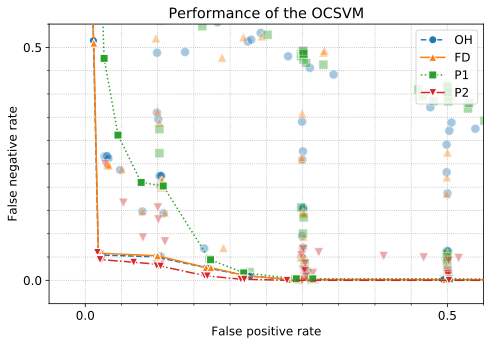

In [20]:
plt.figure(figsize=(7,5))

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_oh)
curve_fpr, curve_fnr = get_curve(sorted_pairs)

ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           marker='o', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot(curve_fpr, curve_fnr, ls='--', marker='o', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='OH')

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_fd)
curve_fpr, curve_fnr = get_curve(sorted_pairs)

ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           marker='^', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot(curve_fpr, curve_fnr, ls='-', marker='^', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='FD')

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_p1)
curve_fpr, curve_fnr = get_curve(sorted_pairs)

ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           marker='s', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot(curve_fpr, curve_fnr, ls=':', marker='s', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='P1')

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_p2)
curve_fpr, curve_fnr = get_curve(sorted_pairs)

ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           marker='v', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot(curve_fpr, curve_fnr, ls='-.', marker='v', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='P2')

plt.title('Performance of the OCSVM')
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
plt.grid(True, which='both')
plt.xticks([0, .5, 1.])
plt.xlim([-0.05, 0.55])
plt.yticks([0, .5, 1.])
plt.ylim([-0.05, .55])
plt.gca().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(10))
plt.gca().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(10))
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'./figures/ocsvm-performance.{figure_format}')
plt.show()

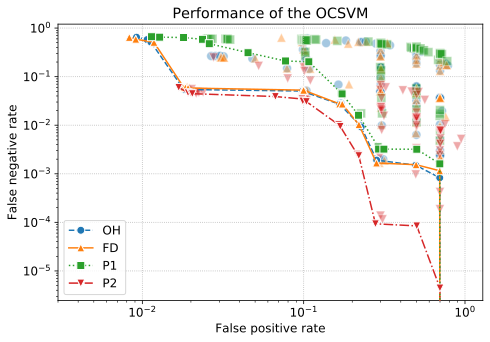

In [21]:
plt.figure(figsize=(7,5))

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_oh)
curve_fpr, curve_fnr = get_curve(sorted_pairs)

ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           marker='o', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot(curve_fpr, curve_fnr, ls='--', marker='o', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='OH')

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_fd)
curve_fpr, curve_fnr = get_curve(sorted_pairs)

ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           marker='^', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot(curve_fpr, curve_fnr, ls='-', marker='^', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='FD')

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_p1)
curve_fpr, curve_fnr = get_curve(sorted_pairs)

ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           marker='s', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot(curve_fpr, curve_fnr, ls=':', marker='s', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='P1')

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_p2)
curve_fpr, curve_fnr = get_curve(sorted_pairs)

ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr],
           marker='v', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot(curve_fpr, curve_fnr, ls='-.', marker='v', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='P2')

plt.title('Performance of the OCSVM')
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.grid(True, ls=':')
plt.legend(loc='lower left')
plt.tight_layout()
xlim = plt.xlim()
plt.xlim([3*1e-3, xlim[1]])
plt.savefig(f'./figures/ocsvm-performance-log.{figure_format}')
plt.show()

In [22]:
with open('./models/results_ocsvm.h5', 'wb') as f:
    pickle.dump({
        'performance_ocsvm_oh': performance_ocsvm_oh,
        'performance_ocsvm_fd': performance_ocsvm_fd,
        'performance_ocsvm_p1': performance_ocsvm_p1,
        'performance_ocsvm_p2': performance_ocsvm_p2,
    }, f)
    
with open('./models/results_dbscan.h5', 'wb') as f:
    pickle.dump({
        'performance_dbscan_oh': performance_dbscan_oh,
        'performance_dbscan_fd': performance_dbscan_fd,
        'performance_dbscan_p1': performance_dbscan_p1,
        'performance_dbscan_p2': performance_dbscan_p2,
    }, f)